# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

<div> <b>Цель исследования:</b><br>
    1. Подготовить прототип модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды<br>
    <br>
    <b>Ход исследования:</b><br>
    1. Выгрузить таблицы<br>
    2. Изучить и подготовить признаки<br>
    3. Построить и обучить модель <br>
    
</div>

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

## Подготовка данных

### Выгрузим и посмотрим на данные.

In [2]:
data_full = pd.read_csv('gold_recovery_full_new.csv')
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')

In [3]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [4]:
data_full.date

0        2016-01-15 00:00:00
1        2016-01-15 01:00:00
2        2016-01-15 02:00:00
3        2016-01-15 03:00:00
4        2016-01-15 04:00:00
                ...         
19434    2018-08-18 06:59:59
19435    2018-08-18 07:59:59
19436    2018-08-18 08:59:59
19437    2018-08-18 09:59:59
19438    2018-08-18 10:59:59
Name: date, Length: 19439, dtype: object

Все значения кроме даты числовые.

### Проверка расчетов.

Посчитаем эффективность флотации и сравним со значениями соответствующей колонки

In [5]:
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'rougher.output.tail_au'

In [6]:
data_train['recovery'] = (data_train[F] - data_train[T]) * data_train[C] / data_train[F] / (data_train[C] - data_train[T]) * 100

In [7]:
print((abs(data_train['recovery'] - data_train['rougher.output.recovery'])).mean())


1.0748911125799084e-14


In [8]:
data_train = data_train.drop('recovery', axis=1)

In [9]:
C = 'final.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'final.output.tail_au'
data_train['recovery'] = (data_train[F] - data_train[T]) * data_train[C] / data_train[F] / (data_train[C] - data_train[T]) * 100
print((abs(data_train['recovery'] - data_train['final.output.recovery'])).mean())
#data_train = data_train.drop('recovery', axis=1)

9.197645354602618e-15


Значения в точности совпадают. Различие в последней цифре после запятой скорее всего связано с методами округления.

Не понятно как связаны параметры входа, выхода и промежуточных состояний для конкретной партии полученные в конкретную секунду.

Предположим что данные уже смещены по времени и в каждой строке находится информация о полном цикле конкретной партии.

### Анализ отсутсвующих признаков

Посмотрим на признаки отстутсвующие в тестовой выборке.

In [10]:
post_cols = []
for i in data_train.columns:
    if i not in data_test.columns:
        post_cols.append(i)
display([post_cols])

[['final.output.concentrate_ag',
  'final.output.concentrate_pb',
  'final.output.concentrate_sol',
  'final.output.concentrate_au',
  'final.output.recovery',
  'final.output.tail_ag',
  'final.output.tail_pb',
  'final.output.tail_sol',
  'final.output.tail_au',
  'primary_cleaner.output.concentrate_ag',
  'primary_cleaner.output.concentrate_pb',
  'primary_cleaner.output.concentrate_sol',
  'primary_cleaner.output.concentrate_au',
  'primary_cleaner.output.tail_ag',
  'primary_cleaner.output.tail_pb',
  'primary_cleaner.output.tail_sol',
  'primary_cleaner.output.tail_au',
  'rougher.calculation.sulfate_to_au_concentrate',
  'rougher.calculation.floatbank10_sulfate_to_au_feed',
  'rougher.calculation.floatbank11_sulfate_to_au_feed',
  'rougher.calculation.au_pb_ratio',
  'rougher.output.concentrate_ag',
  'rougher.output.concentrate_pb',
  'rougher.output.concentrate_sol',
  'rougher.output.concentrate_au',
  'rougher.output.recovery',
  'rougher.output.tail_ag',
  'rougher.output.t

Данные признаки являются выходными параметрами сырья после каждого этапа.

### Пустые поля

In [11]:
def col_select(parametr, data = data_train):
    return data.columns.where((data.columns).str.contains(parametr, na=False)).unique().dropna()

Посмотрим на пустые поля и поля рядом с ними.

In [12]:
data_train[col_select('_level')].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 1   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64
 2   primary_cleaner.state.floatbank8_c_level    14148 non-null  float64
 3   primary_cleaner.state.floatbank8_d_level    14148 non-null  float64
 4   rougher.state.floatbank10_a_level           14148 non-null  float64
 5   rougher.state.floatbank10_b_level           14148 non-null  float64
 6   rougher.state.floatbank10_c_level           14148 non-null  float64
 7   rougher.state.floatbank10_d_level           14149 non-null  float64
 8   rougher.state.floatbank10_e_level           14149 non-null  float64
 9   rougher.state.floatbank10_f_level           14149 non-null  float64
 10  secondary_

Удалим строчку где нет данных о большинстве флотаторов.

In [13]:
data_train = data_train[~data_train['primary_cleaner.state.floatbank8_a_level'].isna()]

Остальные данные интерполируем. Скорее всего значения в близкие периоды времени не будут сильно отличаться.

In [14]:
data_train_ = data_train.copy()
data_train_ = data_train_.interpolate()
data_train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14148 entries, 0 to 14148
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14148 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        14148 non-null  float64
 4   final.output.concentrate_au                         14148 non-null  float64
 5   final.output.recovery                               14148 non-null  float64
 6   final.output.tail_ag                                14148 non-null  float64
 7   final.output.tail_pb                                14148 non-null  float64
 8   final.output.tail_sol                               14148 non-null  float64


В тестовой выборке также интерполируем данные.

In [15]:
data_test = data_test.interpolate()

## Анализ данных

In [16]:
data_full_ = data_full.copy()
data_full_ = data_full_[~data_full_['primary_cleaner.state.floatbank8_a_level'].isna()]
data_full_ = data_full_.interpolate()

### Концентрация металлов

Посмотрим как меняется концентрация металлов.

In [17]:
def print_hist(type_metal, data = data_train):
    plt.figure(figsize=(10,5))
    plt.hist(data[col_select(type_metal, data)], 50, label = col_select(type_metal, data))
    plt.legend(prop={'size': 10});

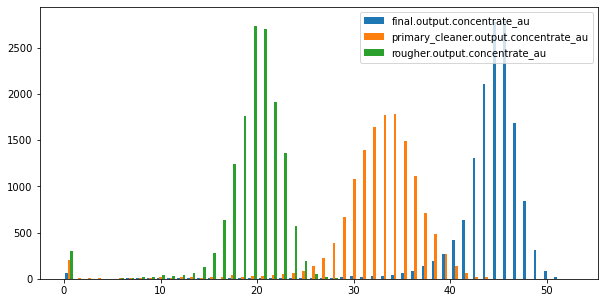

In [18]:
print_hist('concentrate_au')

Как и ожидальсь концентрация золота увеличивается в процессе очистки.

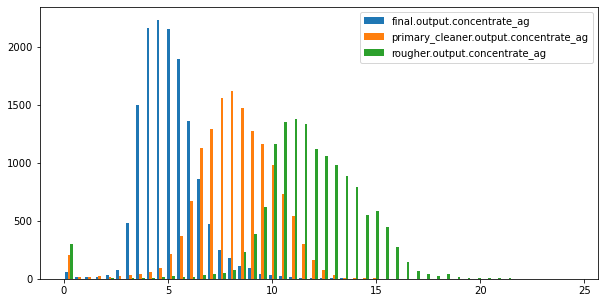

In [19]:
print_hist('concentrate_ag')

Концентрация ртути падает.

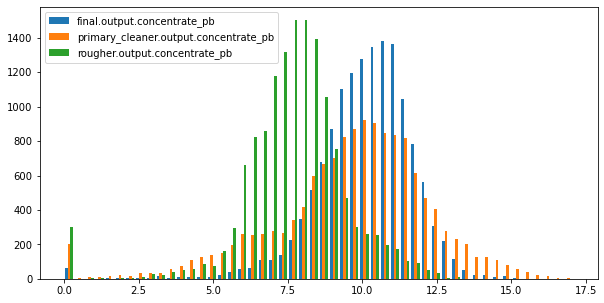

In [20]:
print_hist('concentrate_pb')

Концентрация свинца немного увеличивается после первичной флотации. В процессе последующей очистки не среднее содержание не меняется, но уменьшается дисперсия.

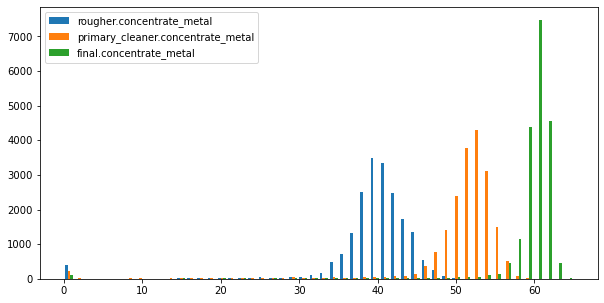

In [21]:
data_full_['rougher.concentrate_metal'] = (
    data_full_['rougher.output.concentrate_au'] +
    data_full_['rougher.output.concentrate_ag'] +
    data_full_['rougher.output.concentrate_pb']
)

data_full_['primary_cleaner.concentrate_metal'] = (
    data_full_['primary_cleaner.output.concentrate_au'] +
    data_full_['primary_cleaner.output.concentrate_ag'] +
    data_full_['primary_cleaner.output.concentrate_pb']
)

data_full_['final.concentrate_metal'] = (
    data_full_['final.output.concentrate_au'] +
    data_full_['final.output.concentrate_ag'] +
    data_full_['final.output.concentrate_pb']
)
data_full_[col_select('metal', data = data_full_)]
print_hist('metal', data_full_)

Концентрация металлов растет в процессе очистки. Заметно значительное количество аномалий, где концентрация всех металлов равна 0. Следует удалить такие данные из обучающей выборки.

In [22]:
data_train_1 = data_train_.copy()
data_train_1[col_select('concentrate')] = data_train_[col_select('concentrate')].where(data_train_[col_select('concentrate')] != 0)

In [23]:
data_train_1 = data_train_1.dropna()

### Размер гранул

Сравним размер гранул обучающей выборки и тестовой.

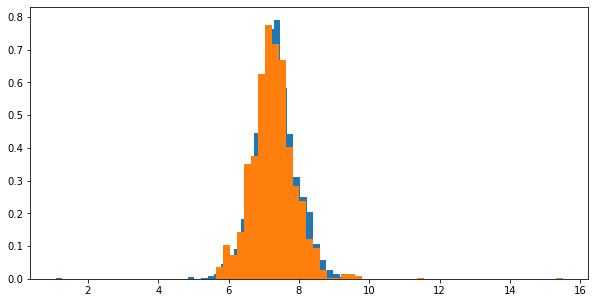

In [24]:
plt.figure(figsize=(10,5))
plt.hist(data_train_1['primary_cleaner.input.feed_size'],50, density=True)
plt.hist(data_test['primary_cleaner.input.feed_size'],50, density=True);

Размер гранул на отчистке совпадает.

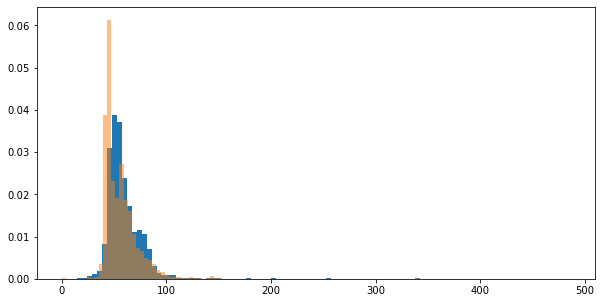

In [25]:
plt.figure(figsize=(10,5))
plt.hist(data_train_1['rougher.input.feed_size'],100,density=True)
plt.hist(data_test['rougher.input.feed_size'],100, alpha = 0.50,density=True);

Размер гранул до первичной флотации отличается. Возможно стоит исключить этот признак. 

### Другие параметры

Посмотрим на распеределения всех параметров выборок.

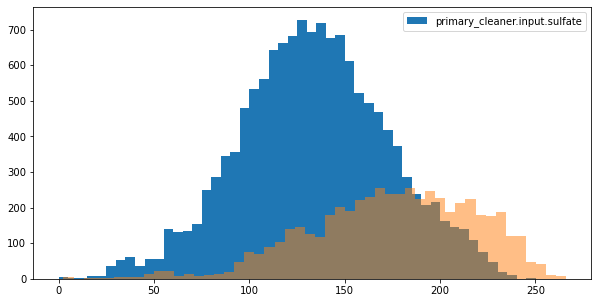

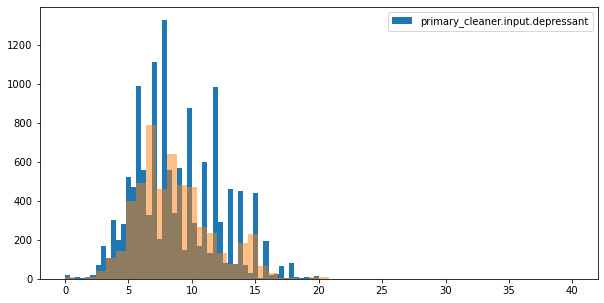

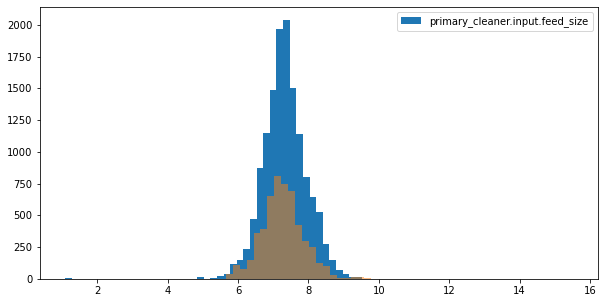

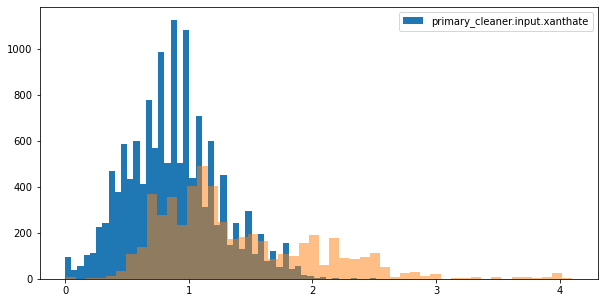

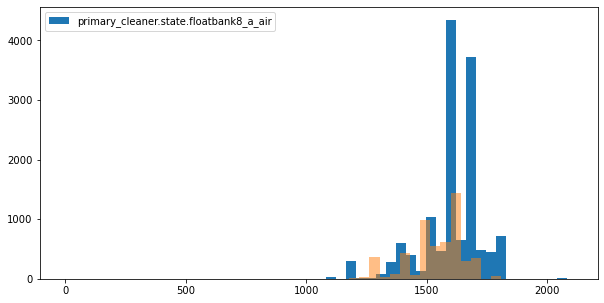

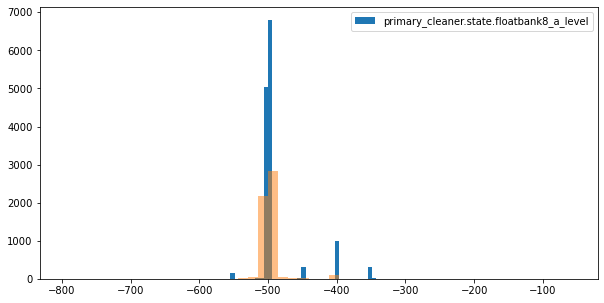

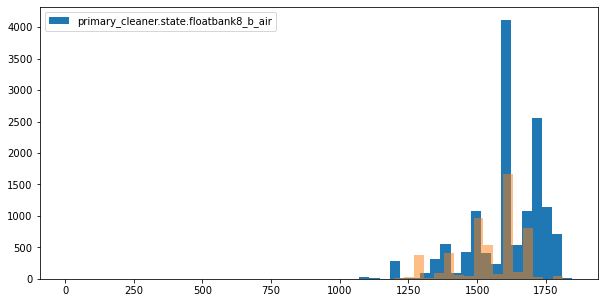

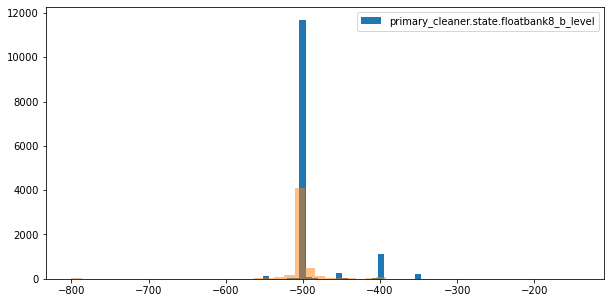

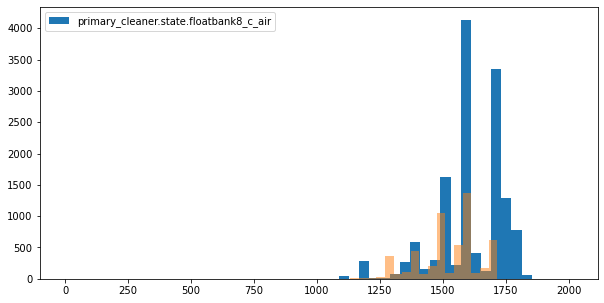

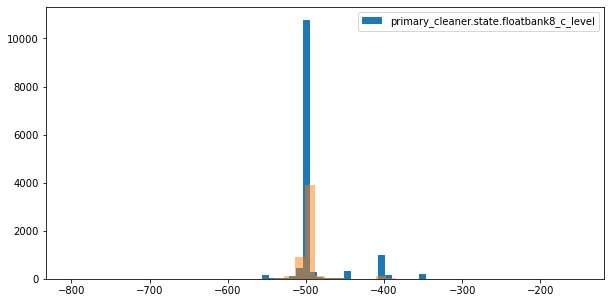

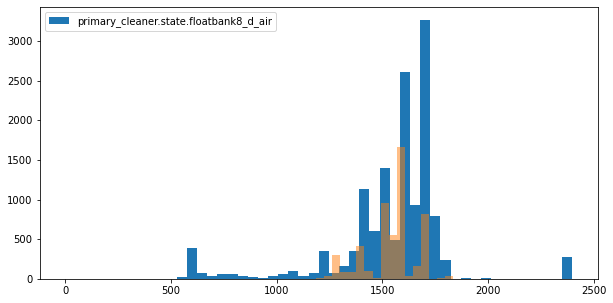

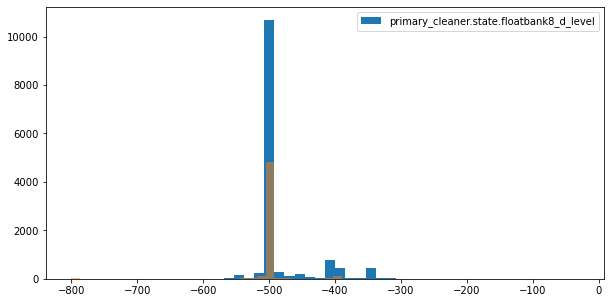

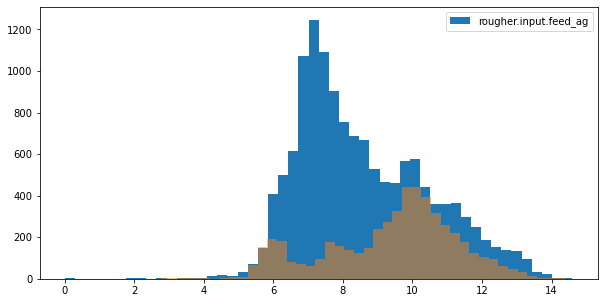

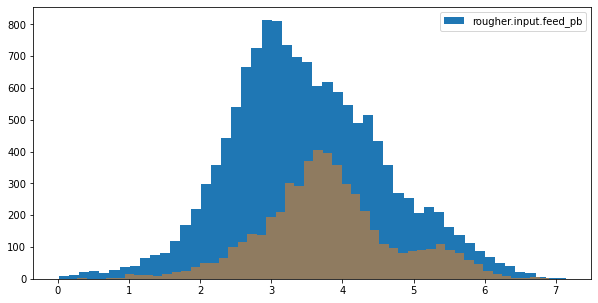

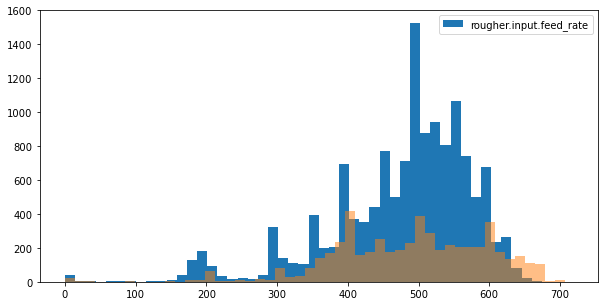

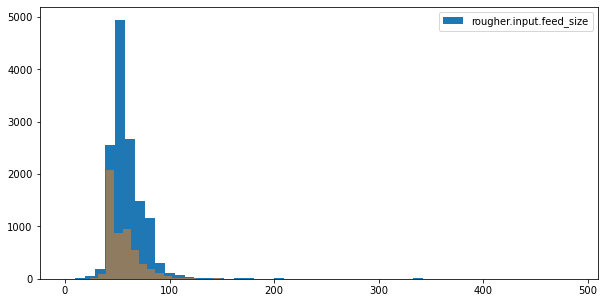

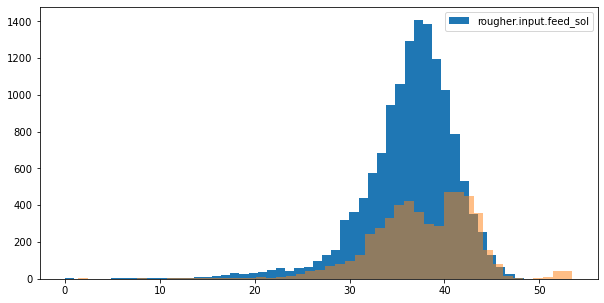

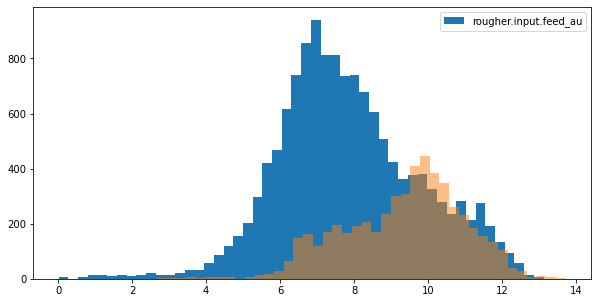

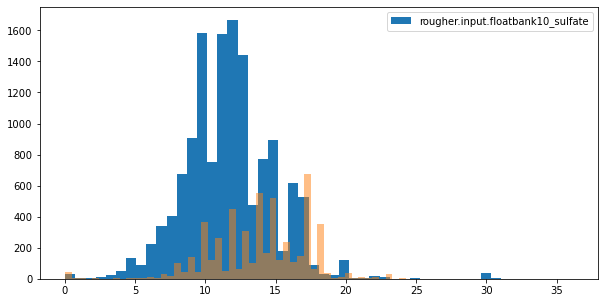

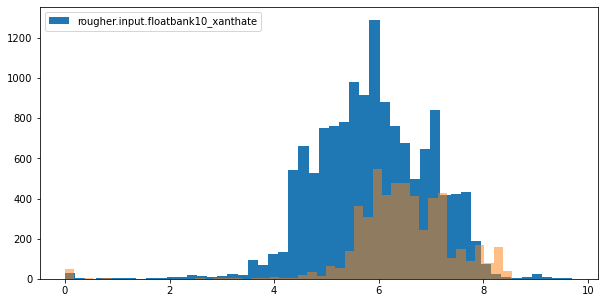

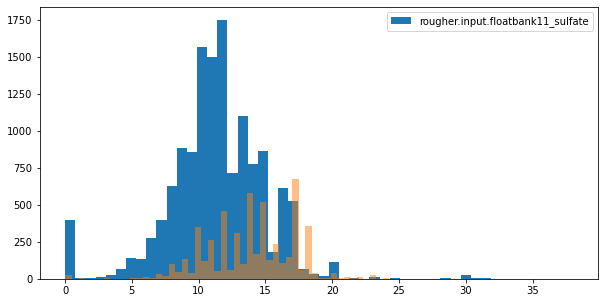

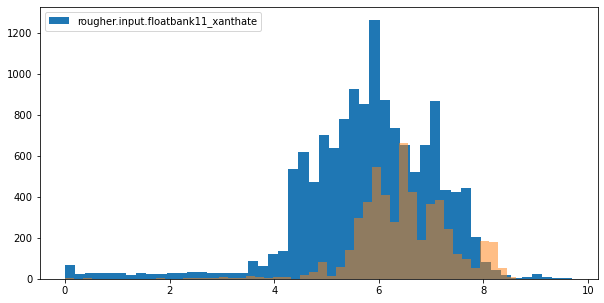

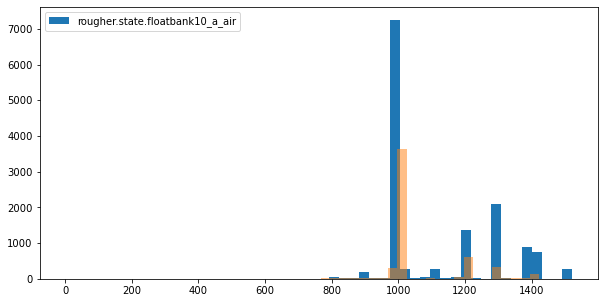

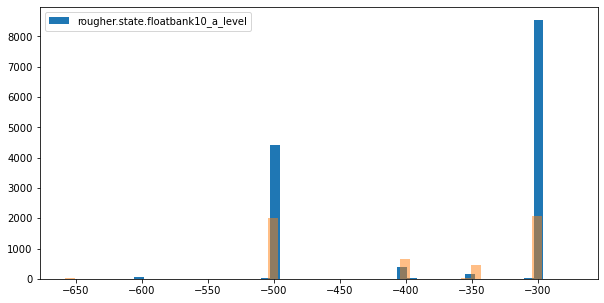

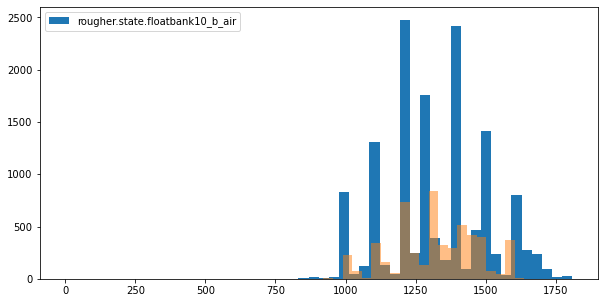

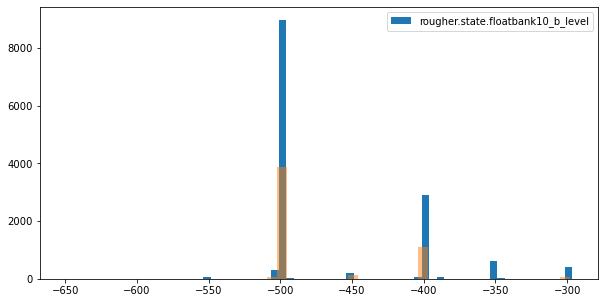

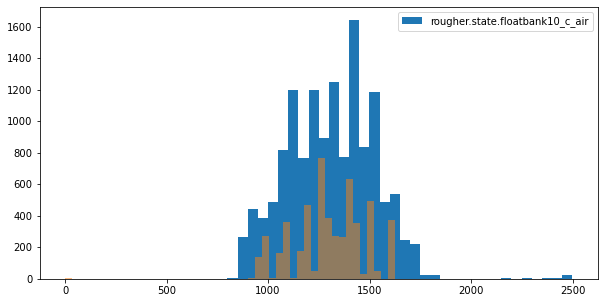

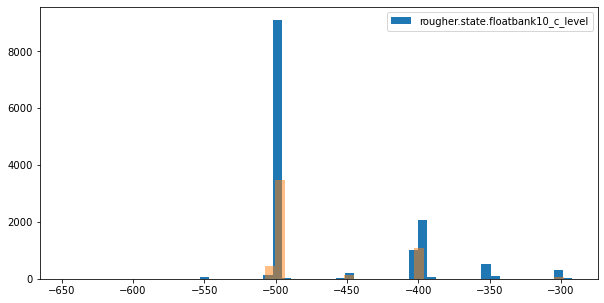

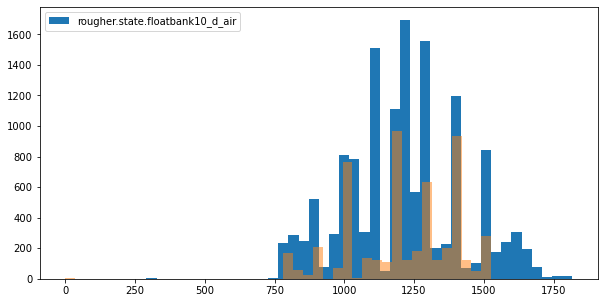

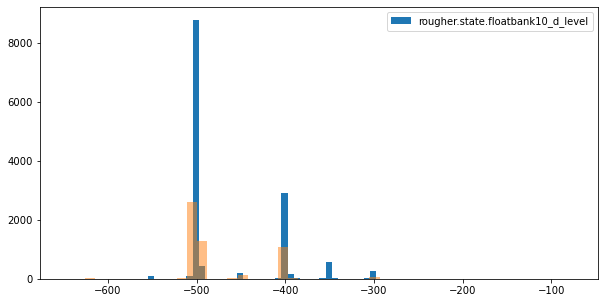

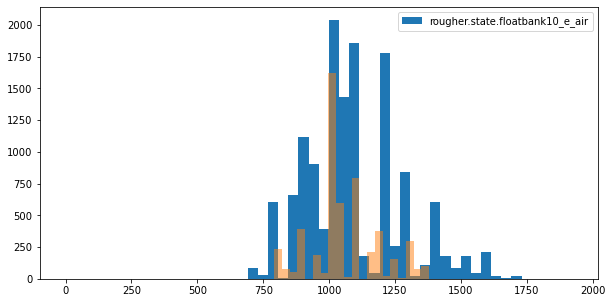

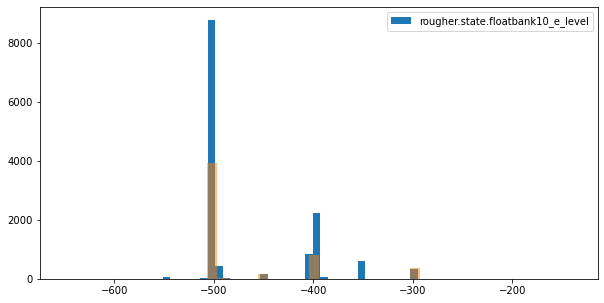

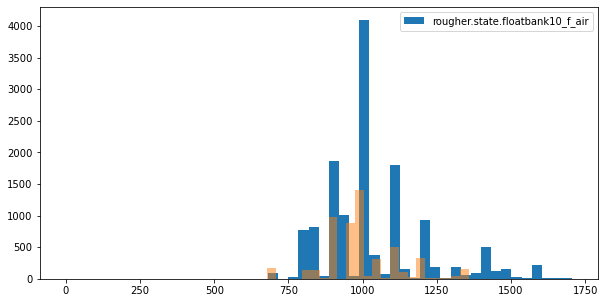

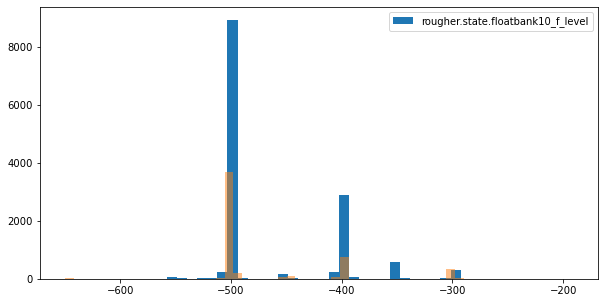

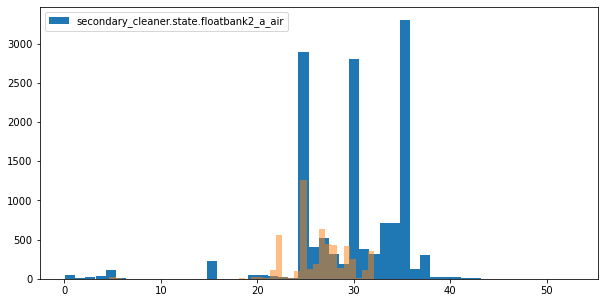

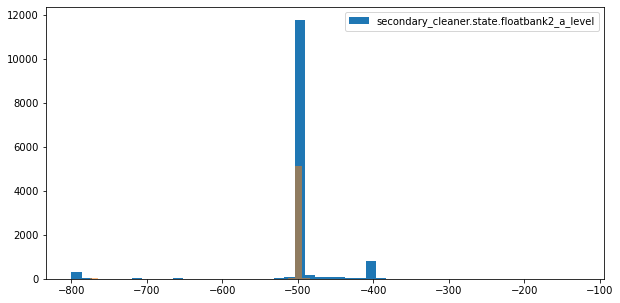

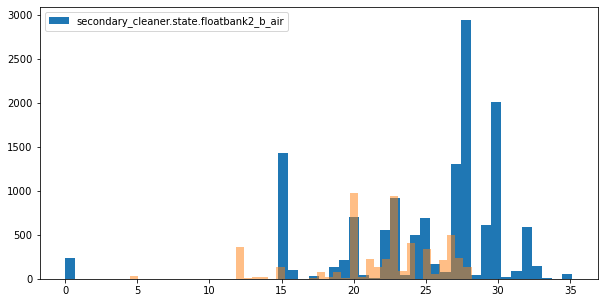

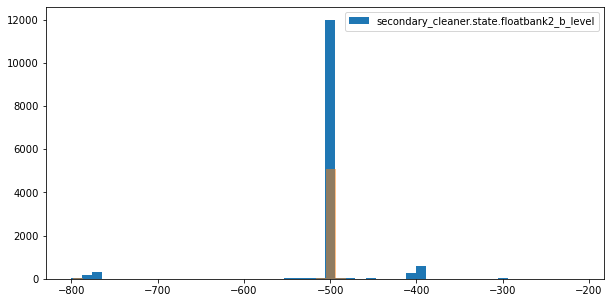

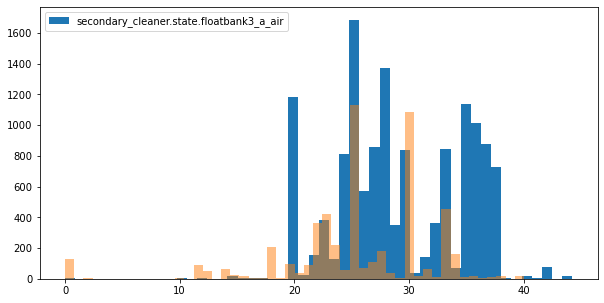

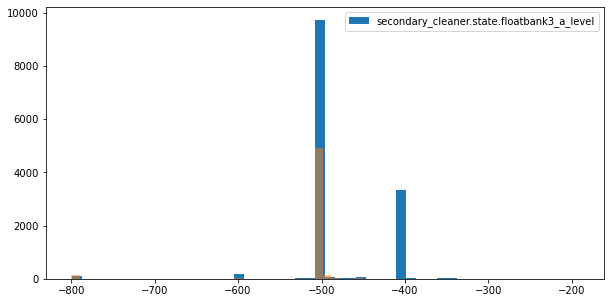

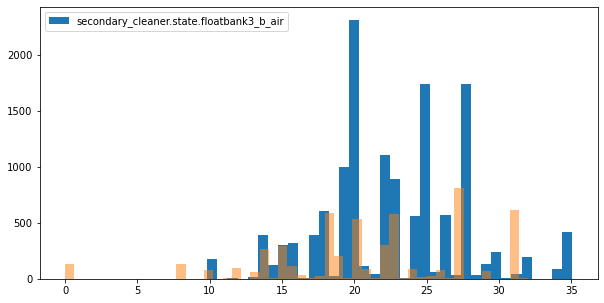

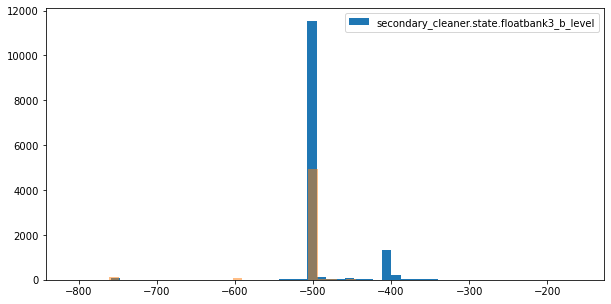

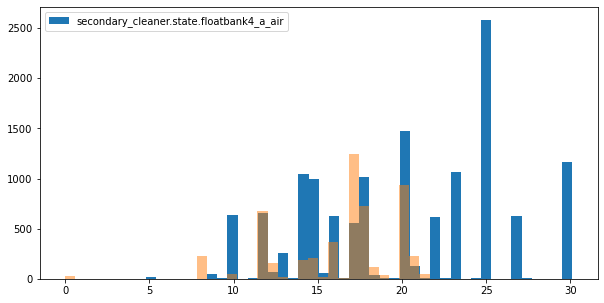

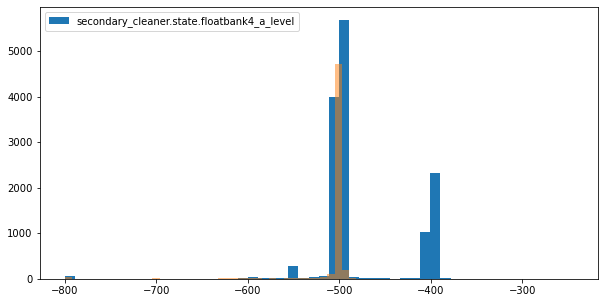

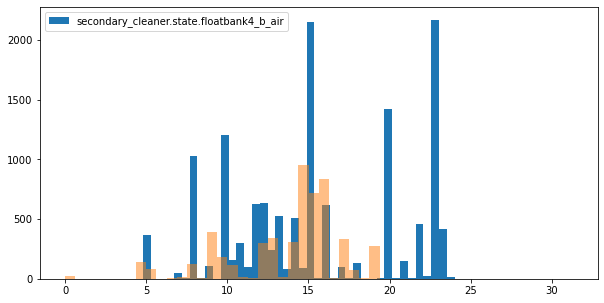

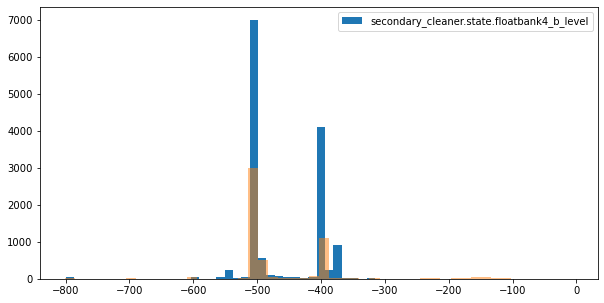

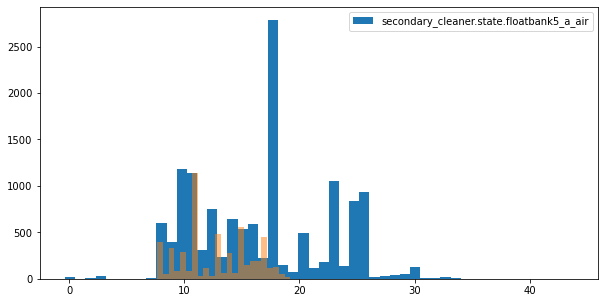

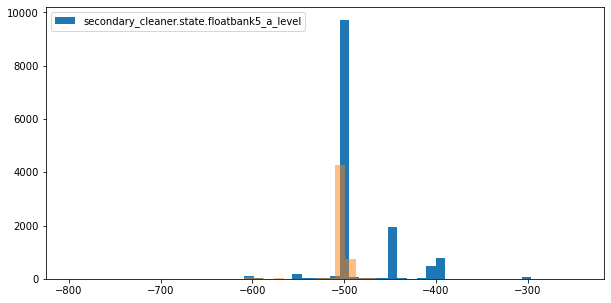

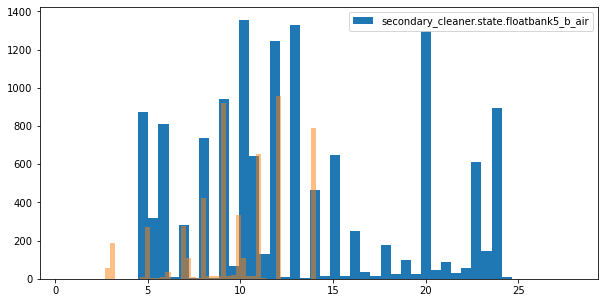

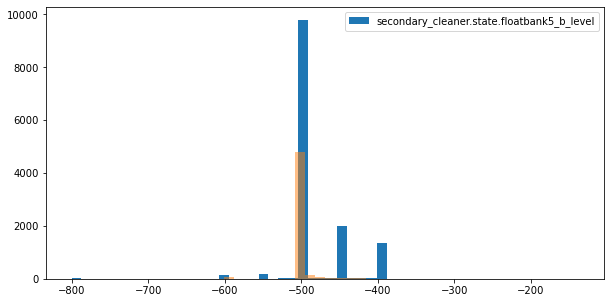

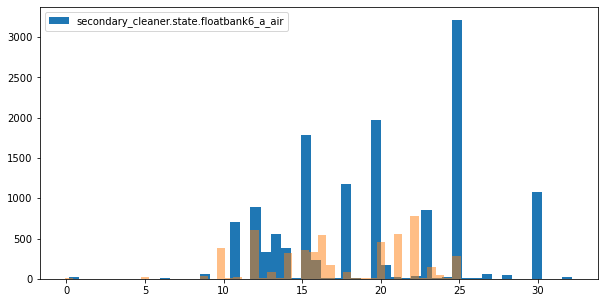

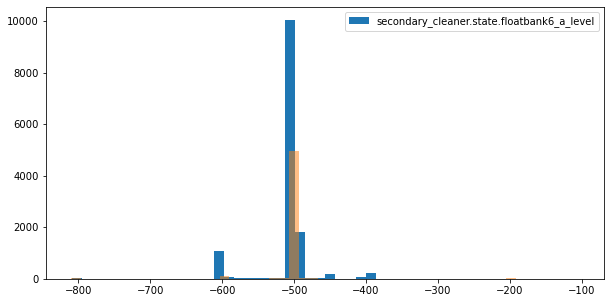

In [26]:
for i in data_test.drop('date', axis=1).columns:
    plt.figure(figsize=(10,5))
    plt.hist(data_train_1[i],50, label = i)
    plt.hist(data_test[i],50, alpha = 0.50)
    plt.legend(prop={'size': 10})
    plt.show();

Из графиков видно, что многие параметры смещены. Возможно их тоже не стоит рассматривать при обучении.

In [27]:
#data_train_1 = data_train_1.drop('rougher.input.feed_size', axis = 1)
#data_test = data_test.drop('rougher.input.feed_size', axis = 1)

## Модель

In [28]:
data_test_y = data_test.merge(data_full[['date','rougher.output.recovery', 'final.output.recovery']], how='inner', on='date')

In [29]:
data_train_rougher = data_train_1[data_test.columns].drop('date', axis = 1)

data_train_rougher_X = data_train_rougher[col_select('rougher', data_test)]
data_train_rougher_y = data_train_1['rougher.output.recovery']

data_train_final_X = data_train_1[data_test.columns].drop('date', axis = 1)
data_train_final_y = data_train_1['final.output.recovery']

data_test_rougher_X = data_test[col_select('rougher', data_test)]

data_test_final_X = data_test.drop('date', axis = 1)

In [43]:
def sMAPE(y_t, y_p):
    y_t.reset_index(drop= True , inplace= True )
    a = pd.concat([y_t.rename('true'),pd.Series(y_p).rename('predict')], axis=1)
    b = (abs(a['true'] - a['predict']) / (a['true'] + a['predict'])).mean()*200
    return(b)
score = make_scorer(sMAPE, greater_is_better=False)

### Линейная регрессия

Построим модель линейной регрессии

In [31]:
pipe_LR = Pipeline([('scaler', StandardScaler()), ('line_mod', LinearRegression())])

In [41]:
cross_val_score(pipe_LR, data_train_rougher_X, data_train_rougher_y, cv=5, scoring=score).mean()

6.4848093319883535

In [33]:
data_train_1['rougher.mean'] = data_train_1['rougher.output.recovery'].median()
data_train_1['final.mean'] = data_train_1['final.output.recovery'].median()

In [34]:
sMAPE(data_train_1['rougher.output.recovery'], data_train_1['rougher.mean'])

7.3038143064032575

Получили результат чуть выше 6.5% для первичной флотации. И это лучше медианного значения.

Возможно линейную модель можно улучшить, если использовать не линейные зависимости.

In [42]:
poly = PolynomialFeatures(2, include_bias=True)
poly_rougher_X = poly.fit_transform(data_train_rougher_X)
cross_val_score(pipe_LR, poly_rougher_X, data_train_rougher_y, cv=5, scoring=score)

array([ 8.60399335,  9.91444916, 15.09745959,  8.13443273,  8.40883834])

Результат получается хуже.

Посмотрим на конечную эффективность.
Удалим информацию о смещеных параметрах.

In [37]:
#data_train_final_X_ = data_train_final_X.drop(['rougher.input.feed_au', 'rougher.input.feed_size',
#        'primary_cleaner.input.sulfate','primary_cleaner.input.xanthate'], axis=1)

In [37]:
cross_val_score(pipe_LR, data_train_final_X, data_train_final_y, cv=5, scoring=score).mean()

-10.972861872512826

Погрешность сильно выше для эффективности отчистки конечного концентрата.

In [44]:
sMAPE(data_train_1['final.output.recovery'], data_train_1['final.mean'])

10.132373831802868

Даже хуже чем медианное значение.

### Случайный лес

Попробуем модель случайного леса.

In [62]:
parametrs = {'n_estimators':range(23, 40), 'max_depth':range(2, 5)}
model_forest = RandomForestRegressor(random_state=777)
grid_forest = GridSearchCV(model_forest, parametrs, cv=5, scoring=score)
grid_forest.fit(data_train_rougher_X, data_train_rougher_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=777),
             param_grid={'max_depth': range(2, 5),
                         'n_estimators': range(23, 40)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [65]:
grid_forest.best_params_

{'max_depth': 3, 'n_estimators': 29}

In [67]:
model_forest_rougher = RandomForestRegressor(n_estimators=29, max_depth=3, random_state=777)
_ = cross_val_score(model_forest_rougher,data_train_rougher_X, data_train_rougher_y, cv=5, scoring=score)
print(_, _.mean())

[-11.17942852  -7.04960383  -4.66510249  -4.34039063  -6.54033392] -6.75497187764284


На первичном этапе точность получилась хуже чем для линейной регрессии, но лучше чем для среднего значения.(6.8%)

In [68]:
parametrs = {'n_estimators':range(23, 40), 'max_depth':range(2, 5)}
model_forest = RandomForestRegressor(random_state=777)
grid_forest_f = GridSearchCV(model_forest, parametrs, cv=5, scoring=score)
grid_forest_f.fit(data_train_final_X, data_train_final_y)
grid_forest_f.best_params_

{'max_depth': 4, 'n_estimators': 38}

In [70]:
grid_forest_final = RandomForestRegressor(n_estimators=38, max_depth=4,random_state=777)
a = cross_val_score(grid_forest_final, data_train_final_X, data_train_final_y, cv=5, scoring=score)
print(a, a.mean())

[-9.49883311 -8.51945705 -9.26037327 -8.37099782 -9.66809262] -9.063550772875644


Для конечного результата модель предсказывает лучше чем медианное значение.

### Проверка на тестовой выборке.

Для финального теста возьмем разные модели.

In [71]:
pipe_LR.fit(data_train_rougher_X, data_train_rougher_y)
rougher_sMAPE = -sMAPE(data_test_y['rougher.output.recovery'],pipe_LR.predict(data_test_rougher_X))

grid_forest_final.fit(data_train_final_X, data_train_final_y)
final_sMAPE = -sMAPE(data_test_y['final.output.recovery'], grid_forest_final.predict(data_test_final_X))
result = rougher_sMAPE * 0.25 +  final_sMAPE * 0.75

In [72]:
-result

9.348475934068501

In [82]:
data_test_y['rougher.mean'] = data_train_1['rougher.output.recovery'].median()
data_test_y['final.mean'] = data_train_1['final.output.recovery'].median()

In [83]:
mean_sMAPE = (sMAPE(data_test_y['rougher.output.recovery'], data_test_y['rougher.mean'])*0.25 +
               sMAPE(data_test_y['final.output.recovery'], data_test_y['final.mean'])*0.75)
mean_sMAPE

9.441670480227607

Наши предсказания немного лучше медиан.

In [78]:
state = np.random.RandomState(12345)
values_r = []
values_f = []
mean_sMAPE_m = []
for i in range(1000):
    subsample_r = data_train_1[['rougher.output.recovery','final.output.recovery']].sample(1, replace=False, random_state=state)
    values_r.append(subsample_r['rougher.output.recovery'].mean())
    values_f.append(subsample_r['final.output.recovery'].mean())
    data_test_y['rougher.mean'] = values_r[i]
    data_test_y['final.mean'] = values_f[i]
    mean_sMAPE_m.append(sMAPE(data_test_y['rougher.output.recovery'], data_test_y['rougher.mean'])*0.25 +
    sMAPE(data_test_y['final.output.recovery'], data_test_y['final.mean'])*0.75)
s = pd.Series(mean_sMAPE_m)

In [79]:
s[s < -result].shape[0]/1000

0.129

Существуют константные предсказания лучше построеной модели.

##  Вывод

Были получены данные о переработке золотосодержащей руды. Проверен расчет целевого признака. Проведена предобработка данных, пустые поля были заполнены или удалены. Также были удалены строки обучающей выборки, где концентрация металлов равна 0. Удалены из рассмотрения параметры сильно смещеные в обучающей и тестовой выборке. 

Были построены две модели: линейная регрессия и случайный лес. Для первичной обработки сырья линейная регрессия показала результат немного лучше, эту модель взяли для теста. Конечную эффективность лучше предсказала модель случайного леса, на тесте использовали ее.

Окончательный результат получился ~ 9.3%. Он оказался лучше предсказания медианным значением, но с огромной вероятностью случайные числа обучающей выборки "предсказывают" лучше.

Необходимо уточнить что означают данные в таблице, возможно в одной строке данные о разных партиях сырья и мы хотим получить информацию о старой руде по данным о новой. Если это так, то необходимо уточнить информацию о технологическом процессе и сдвинуть значения колонок.